# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
1. Your code must run without errors. Make sure your `numpy` version is at least 1.15.4 and that you are using at least python 3.6. Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: 323081950, 227367455

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x7fda8106da00>, <__main__.Node at 0x7fda8106da90>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
#############################################################################
# TODO: Find the columns with missing values and remove them from the data.#
#############################################################################
data.dropna(axis='columns',inplace=True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [7]:
DEFAULT_CLASS_INDEX = -1

def count_values(data, feature=DEFAULT_CLASS_INDEX, return_counts=True):
    """
    Counts how many of each tag the given feaure has in the dataset
        
    Input:
    - data: any dataset that contains the requested feature column
    - feature: the feature for which to count possible tag. If -1, then return all values for all features
    - return_counts: whether to return the count of each value or just a list of the values
    
    Returns a list of all tags the selected feature in the given dataset
    """
    return np.unique(data[:,feature], return_counts=return_counts)

In [8]:
def enum_values(data, feature):
    """
    Computes which tags the given feature has in the dataset
    
    Input:
    - data: any dataset that contains the requested feature column
    - feature: the feature for which to enumerate possible tags
    
    Returns a list of all tags of the requested in the given dataset
    """
    return count_values(data, feature, return_counts=False)

In [9]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    space_size = len(data)
    # becomes an array of the values squared / m
    gini = np.square(count_values(data)[1] / space_size)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return 1.0 - np.sum(gini)

In [10]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    space_size = len(data)
    # The array of probabilities of the dataset
    probabilities = count_values(data)[1] / space_size
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return -np.sum(probabilities * np.log2(probabilities))

In [11]:
##### Your Tests Here #####
equal_distribution = np.ones(100).reshape(10,10)
unequal_distribution = np.arange(100).reshape(10,10)

print("gini,entropy")
print("Equal distributions:")
# Should be 0.0, 0.0
print(calc_gini(equal_distribution), calc_entropy(equal_distribution))

print("Unequal distributions:")
# Shoudl be something close to 1 and something big
print(calc_gini(unequal_distribution), calc_entropy(unequal_distribution))

print("Dataset:")
print(calc_gini(X), calc_entropy(X))

gini,entropy
Equal distributions:
0.0 -0.0
Unequal distributions:
0.8999999999999999 3.321928094887362
Dataset:
0.4995636322379775 0.9993703627906085


## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [12]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns a tuple of the following:
    - the goodness of split (or the Gain Ration),
    - a dictionary mapping a tag name (based on the feature in the arguments) to a list of instances with the given tag
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    if gain_ratio:
        goodness, split_feature_dict = goodness_of_split(data, feature, impurity_func)
        split_info = impurity_func(data[:,[feature]])
        # if goodness is 0 we check for spliting
        if split_info:
            goodness /= split_info
        else: 
            goodness = 0
    else:
        space_size = len(data)
        feature_values =  enum_values(data, feature)
        # Compute which instances have the given tag for the future
        split_feature_dict = {value : data[data[:,feature] == value] for value in feature_values}
        # Notice that len(split_feature_dict[tag]) for some tag is the # of instances with the given tag
        goodness = impurity_func(data) - (sum(len(split_feature_dict[value]) * impurity_func(split_feature_dict[value]) 
                                                         / space_size  for value in feature_values))
        
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return goodness, split_feature_dict

In [13]:
def best_feature(data, impurity_func, gain_ratio=False):
    """
    Finds the best feature to split with for a dataset
    
    Input:
    - data: any dataset with at least one feature
    - impurity_func: the impurity function to use to determine the best feature
    - gain_ratio: whether to use gain_ratio for computing impurity
    
    Returns a tuple of the following values:
    - The name of the best feature using the impurity function
    - Goodness value of splitting by the returned feature
    - Dictionary mapping tag name to instances with the given tag, based on the best_feature
    """
    goodness = -1
    split_feature_dict = {}
    best_feature = -1
    # Last column is a label, so we don't split it and do - 1
    for feature in range(data.shape[1] - 1):
        # What is the split of this
        tmp_goodness, tmp_split_feature_dict = goodness_of_split(data, feature, impurity_func, gain_ratio=gain_ratio)
        if tmp_goodness > goodness:
            goodness = tmp_goodness
            split_feature_dict = tmp_split_feature_dict
            best_feature = feature
    return best_feature, goodness, split_feature_dict

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [14]:
from copy import deepcopy

class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """

    def __init__(self, feature, feature_value, labels:dict):
        """
        Input:
        - feature: column index of the criteria being tested by this node
        - feature_value: tag name that this node represents
        - A dictionary mapping label name to amount of instances with label in this node
        """
        self.feature = feature # column index of criteria being tested
        self.feature_value = feature_value
        self.labels = labels
        self.children = {}
        self.parent = None
        

    def add_child(self, node):
        """
        Adds a DecisionNode to be a child of this node, creating a subtree rooted by `self`

        Input:
        - node: A DecisionNode to add as a child
        """
        if not node:
            return
        self.children[node.feature_value] = node
        node.parent = self
    

    def copy(self):
        """
        Copies a DecisionNode

        Returns a deep copy of this DecisionNode
        """
        return deepcopy(self)
        

    def delete(self):
        """
        Deletes this DecisionNode

        Used for easily deleting a node from a decision tree.
        """
        del self.parent.children[self.feature_value]
        del self
    
    def __repr__(self):
        return str(self)
    
    @property
    def pred(self):
        """
        Returns what the prediction would be on that specific node
        """
        return max(self.labels, key=self.labels.get)
    
    @property
    def height(self):
        """
        The height of this tree (how many layers of children it has)
        """
        if self.children:
            return 1 + max(child.height for child in self.children.values())
        else:
            return 0
        
    def switch_parent_child(self, other_node):
        other_node.parent = self.parent
        other_node.parent.children[self.feature_value] = other_node
     
    def reverse_switch_parent_child(self, other_node):
        other_node.parent = self
        other_node.parent.children[self.feature_value] = self

    @staticmethod 
    def get_label(data):
        """
        Counts the distribution of label names for a given dataset

        Inputs:
        - data: A dataset with labels for whicht o count

        Returns a dict mapping label name to amount of instances with label
        """
        tag, count = count_values(data)
        return dict(zip(tag, count))
        

    def __str__(self):
        """
        Represents this DecisionNode as a string
        """
        if not self.parent:
            return f"[ROOT, feature={self.feature}]"
        elif not self.children:
            return f"[{self.parent.feature}={self.feature_value}, leaf]: [{self.labels}]"
        else:
            return f"[{self.parent.feature}={self.feature_value}, feature={self.feature}]"

    def recursive_print(self, tab="\t", depth=0):
        """
        Prints the entire tree and all subtrees

        Input:
        - tab: which indentation character to use for deeper nodes
        - depth: current depth of this node in the tree
        """
        print(tab * depth, self)
        for child in self.children:
            self.children[child].recursive_print(tab, depth + 1)
        

In [15]:
def chi_square_test(data):
    """
    Calculates the Chi square test for a given dataset
    
    Input:
    - data: a dataset
    
    Returns the Chi squared value for the dataset
    """
    label_values, label_counts = count_values(data)
    tags, counts = count_values(data, feature = 0)
    
    len_class = len(label_values)
    len_feature = len(tags)

    df = (len_class - 1) * (len_feature - 1)

    # Matrix of expected values
    exp_matrix = np.outer(label_counts, counts) / data.shape[0]

    # Matrix of actual values
    actual_matrix = [[((data[:,0] == tag) & (data[:,1] == label)).sum() for tag in tags] for label in label_values]
    
    chi = (np.square(actual_matrix - exp_matrix) / exp_matrix).sum()

    return chi, df

In [16]:
def build_tree(data, impurity, gain_ratio=False, chi=1, max_depth=500, feature_value=None, chi_table=None):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - chi: chi square p-value cut off (1 means no pruning)
    - max_depth: the allowable depth of the tree
    - feature_value: which tag name to use as the split for the root
    - chi_table: a chi distribution table to use for chi pruning

    Output: the root node of the tree.
    """
    root = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    
    feature, goodness, split_feature_dict = best_feature(data, impurity, gain_ratio=gain_ratio)

    root = DecisionNode(feature, feature_value, DecisionNode.get_label(data))
        
    if not (goodness and max_depth):
        return root
    
    # we pass in only the feature and class columns
    chi_value, df = chi_square_test(data[:,[feature, -1]])
        
    if chi != 1 and chi_value < chi_table[df].get(chi, 0):
        return root
    
    for value in split_feature_dict:
        
        label_values, label_counts = count_values(split_feature_dict[value])
        
        child = build_tree(split_feature_dict[value], impurity, gain_ratio, chi, max_depth - 1, value, chi_table)
        
        root.add_child(child)
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root

In [17]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [18]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    while(node.children):
        instance_feature = instance[node.feature]
        if instance_feature in node.children:
            # Go down into the node corresponding the feature
            node = node.children[instance_feature]
        else:
            break
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return node.pred

In [37]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    predictions = [predict(node, dataset[i]) for i in range(dataset.shape[0])]
    success = np.count_nonzero(predictions == dataset[:,-1])
    accuracy = success / dataset.shape[0]
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [38]:
#### Your code here ####
# Take the most accurate one of the three trees
best_tree = max([tree_gini, tree_entropy, tree_entropy_gain_ratio], key= lambda tree: calc_accuracy(tree, X_test))

## Post pruning

Iterate over all nodes in the tree that have at least a single child which is a leaf. For each such node, replace it with its most popular class. Calculate the accuracy on the testing dataset, pick the node that results in the highest testing accuracy and permanently change it in the tree. Repeat this process until you are left with a single node in the tree (the root). Finally, create a plot of the training and testing accuracies as a function of the number of nodes in the tree. (15 points)

In [39]:
def prune_leaves(root):
    """
    Prune the leaves of a decision tree
    
    Input:
    - root: DecisionNode root fo the decision tree for which to prune the leaves of
    """
    if root.children:
        for child in list(root.children.keys()):
            prune_leaves(root.children[child])
    else:
        root.delete()

In [40]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    return 1 + sum(count_nodes(child_node) for child_node in node.children.values())
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    

In [41]:
def post_pruning(tree_node, test_data):
    """
    Performs the post pruning process on a decision tree
    
    Input:
    - tree_node: the DecisionNode that is the root of the decision tree to post prune
    - test_data: a dataset that represents the testing set (for which to decide what to prune)
    
    Returns a tuple of the following:
    - A list representing the history of amount nodes for every pruning iteration
    - A list representing the history of accuracy for every pruning iteration
    """
    history_nodes = [count_nodes(tree_node)]
    history_accuracy = [calc_accuracy(tree_node, test_data)]
    tree_node = tree_node.copy()
    while tree_node.children:
        prune_leaves(tree_node)
        nb_nodes = count_nodes(tree_node)
        accuracy = calc_accuracy(tree_node, test_data)
        history_nodes.append(nb_nodes)
        history_accuracy.append(accuracy)

    return history_nodes, history_accuracy

In [42]:
history_nodes, history_accuracy = post_pruning(tree_entropy_gain_ratio, X_test)

ymax = max(history_accuracy)
nb_of_prunings = history_accuracy.index(ymax)

# See progress of the post pruning
print(history_nodes, history_accuracy)

[3251, 1359, 908, 562, 316, 157, 72, 35, 19, 11, 7, 4, 2, 1] [0.7853274249138356, 0.8306253077301822, 0.8724766125061546, 0.8902018709995076, 0.8931560807483998, 0.8906942392909897, 0.8828163466272771, 0.8645987198424422, 0.8335795174790743, 0.7159034958148696, 0.7159034958148696, 0.7159034958148696, 0.5061546036435254, 0.5061546036435254]


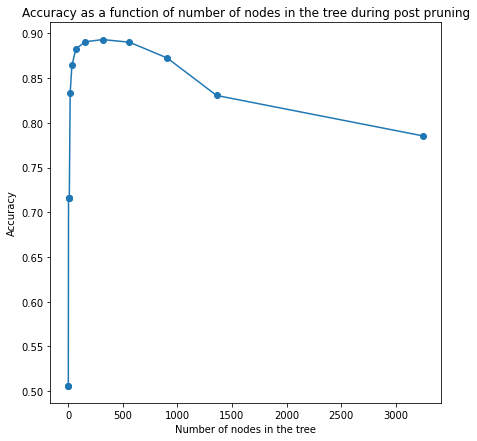

In [43]:
history_nodes, history_accuracy = post_pruning(tree_entropy_gain_ratio, X_test)

plt.figure(figsize=(7, 7))
plt.plot(history_nodes, history_accuracy, marker="o")
plt.xlabel('Number of nodes in the tree')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of number of nodes in the tree during post pruning')
plt.show()

## Chi square pre-pruning

Consider the following p-value cut-off values: [1 (no pruning), 0.5, 0.25, 0.1, 0.05, 0.0001 (max pruning)]. For each value, construct a tree and prune it according to the cut-off value. Next, calculate the training and testing accuracy. On a single plot, draw the training and testing accuracy as a function of the tuple (p-value, tree depth). Mark the best result on the graph with red circle. (15 points)

In [44]:
### Chi square table values ###
# The first key is the degree of freedom 
# The second key is the p-value cut-off
# The values are the chi-statistic that you need to use in the pruning
chi_table = {1: {0.5 : 0.45,
                 0.25 : 1.32,
                 0.1 : 2.71,
                 0.05 : 3.84,
                 0.0001 : 100000},
             2: {0.5 : 1.39,
                 0.25 : 2.77,
                 0.1 : 4.60,
                 0.05 : 5.99,
                 0.0001 : 100000},
             3: {0.5 : 2.37,
                 0.25 : 4.11,
                 0.1 : 6.25,
                 0.05 : 7.82,
                 0.0001 : 100000},
             4: {0.5 : 3.36,
                 0.25 : 5.38,
                 0.1 : 7.78,
                 0.05 : 9.49,
                 0.0001 : 100000},
             5: {0.5 : 4.35,
                 0.25 : 6.63,
                 0.1 : 9.24,
                 0.05 : 11.07,
                 0.0001 : 100000},
             6: {0.5 : 5.35,
                 0.25 : 7.84,
                 0.1 : 10.64,
                 0.05 : 12.59,
                 0.0001 : 100000},
             7: {0.5 : 6.35,
                 0.25 : 9.04,
                 0.1 : 12.01,
                 0.05 : 14.07,
                 0.0001 : 100000},
             8: {0.5 : 7.34,
                 0.25 : 10.22,
                 0.1 : 13.36,
                 0.05 : 15.51,
                 0.0001 : 100000},
             9: {0.5 : 8.34,
                 0.25 : 11.39,
                 0.1 : 14.68,
                 0.05 : 16.92,
                 0.0001 : 100000},
             10: {0.5 : 9.34,
                  0.25 : 12.55,
                  0.1 : 15.99,
                  0.05 : 18.31,
                  0.0001 : 100000},
             11: {0.5 : 10.34,
                  0.25 : 13.7,
                  0.1 : 17.27,
                  0.05 : 19.68,
                  0.0001 : 100000}}

In [45]:
#### Your code here ####
p_values = [1, 0.5, 0.25, 0.1, 0.05, 0.0001]

In [46]:
def chi_cut_off(data, test_data, impurity, gain_ratio, p_values, chi_table):
    """
    Computes the accuracies and depth of creating a decision tree based on a series of p-value cutoffs
    
    Input:
    - data: a dataset to run on
    - test_data: a subset of the dataset to use as the testing data
    - impurity: the impurity function to decide how to split
    - gain_ratio: whether to use gain_ratio in the impurity func
    - p_values: a list of p-value cutoffs to try
    - chi_table: a table of chi square distribution values
    
    Returns a tuple of the following:
    - a list representing the history of accuracy on the testing set for each p_value
    - a list representing the history of accuracy on the whole dataset for each p_value
    - a list representing the history of accuracy on the testing set for each p_value

    """
    history_accuracy_test = []
    history_accuracy_data = []
    history_depth = []
    for chi in p_values:
        tree_node = build_tree(data=data, chi=chi, chi_table=chi_table, impurity=impurity, gain_ratio=gain_ratio)
        accuracy_data = calc_accuracy(tree_node, data)
        accuracy_test = calc_accuracy(tree_node, test_data)
        history_accuracy_test.append(accuracy_test)
        history_accuracy_data.append(accuracy_data)
        history_depth.append(tree_node.height)
    return history_accuracy_data, history_accuracy_test, history_depth

In [47]:
history_accuracy_data, history_accuracy_test, history_depth = chi_cut_off(X_train, X_test, calc_entropy, 
                                                    gain_ratio=True, p_values =p_values, chi_table=chi_table)

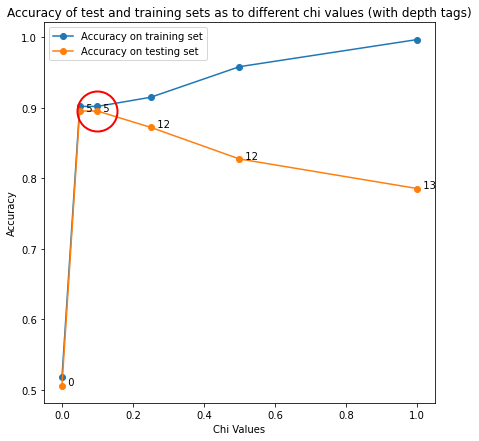

In [48]:
ymax = max(history_accuracy_test)
xpos = history_accuracy_test.index(ymax)
best_chi = p_values[xpos]


plt.figure(figsize=(7, 7))
plt.plot(p_values, history_accuracy_data, marker="o")
plt.plot(p_values, history_accuracy_test, marker="o")
            
for x, y, depth in zip(p_values, history_accuracy_test, history_depth):
    plt.text(x, y,"  "+str(depth))

plt.plot(best_chi, ymax, 'o', ms=20 * 2, mec='r', mfc='none', mew=2)

plt.xlabel('Chi Values')
plt.ylabel('Accuracy')
plt.title('Accuracy of test and training sets as to different chi values (with depth tags)')
plt.legend(["Accuracy on training set", "Accuracy on testing set"])
plt.show()

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_chi - the best tree according to chi square pruning

In [31]:
#### Your code here ####
best_chi_tree = build_tree(data=X_train, chi=best_chi, impurity=calc_entropy, gain_ratio=True, chi_table=chi_table)
best_post_pruning_tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True)

for i in range(nb_of_prunings):
    prune_leaves(best_post_pruning_tree)

## Number of Nodes

Of the two trees above we will choose the one with fewer nodes. Complete the function counts_nodes and print the number of nodes in each tree. (5 points) 

In [32]:
# Take smallest node amont of the trees
best_tree = min([best_chi_tree, best_post_pruning_tree], key= lambda tree: count_nodes(tree))

## Print the tree

Complete the function `print_tree` and execute it on your chosen tree. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [33]:
# you can change the function signeture\n",
def print_tree(node):
    """
        prints the tree according to the example above
        
        Input:
         - node: a node in the decision tree
         
        This function has no return value
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    #This method is just an alias
    node.recursive_print(tab="  ")
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

In [34]:
print_tree(best_tree)

 [ROOT, feature=4]
